# Problema 3 - Previsão de Preços de Ações com RNN e LSTM

Este notebook tem como objetivo demonstrar o **problema do gradiente desvanecente** em uma RNN Simples e como a **LSTM o resolve** em uma tarefa de previsão de séries temporais do mundo real: a previsão de preços de ações.

## Objetivo
- Treinar uma **RNN Simples** para prever o preço de fechamento das ações da Google.
- Treinar uma **LSTM** para a mesma tarefa.
- Comparar visualmente os resultados e demonstrar por que a LSTM é superior para capturar dependências de longo prazo em dados sequenciais.

## Dataset
Utilizaremos o histórico de preços de ações da Google, focando no preço de fechamento (`Close`).

## 1. Importação das Bibliotecas e configuração

Vamos importar todas as bibliotecas necessárias para o projeto e setar o TensorFlow para utilizar mixed precision, se possível.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Configurar seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

import tensorflow as tf
from tensorflow.keras import mixed_precision

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("TensorFlow version:", tf.__version__)

mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
Num CPUs Available:  1
TensorFlow version: 2.20.0


## 2. Carregamento e Análise Exploratória dos Dados (EDA)

Vamos carregar o dataset e fazer uma análise inicial para entender sua estrutura e características.

In [4]:
# Carregar o dataset
df = pd.read_csv('./dataset/google_stock.csv')

# Converter a coluna 'Date' para o formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Definir a data como índice
df.set_index('Date', inplace=True)

# Selecionar apenas a coluna 'Close'
data = df[['Close']]

print("### Informações do Dataset ###")
data.info()

print("\n### Primeiras 5 Linhas ###")
print(data.head())

print("\n### Estatísticas Descritivas ###")
data.describe()

### Informações do Dataset ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4858 entries, 2004-08-19 to 2023-12-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4858 non-null   float64
dtypes: float64(1)
memory usage: 75.9 KB

### Primeiras 5 Linhas ###
               Close
Date                
2004-08-19  2.499133
2004-08-20  2.697639
2004-08-23  2.724787
2004-08-24  2.611960
2004-08-25  2.640104

### Estatísticas Descritivas ###


,Close
count,4858.000000
mean,41.494404
std,38.618107
min,2.490913
25%,12.834642
50%,26.537501
75%,57.611249
max,150.709000


### 2.1 Visualização da Série Temporal

Vamos plotar o preço de fechamento ao longo do tempo para visualizar a série temporal.

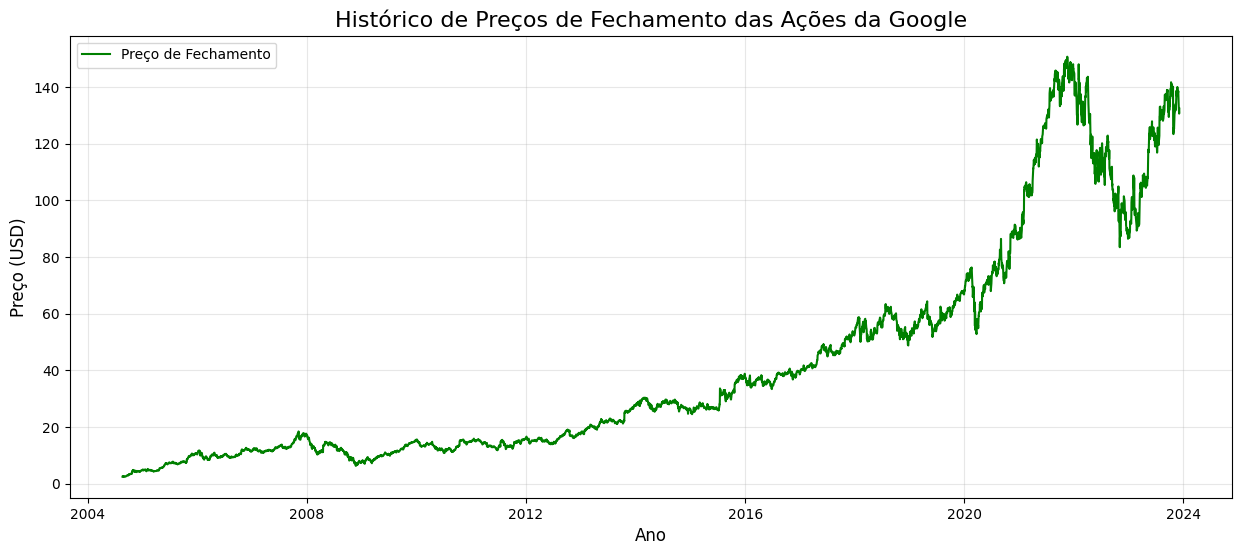

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(data['Close'], label='Preço de Fechamento', color='green', linewidth=1.5)
plt.title('Histórico de Preços de Fechamento das Ações da Google', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Pré-processamento dos Dados

### 3.1 Normalização

Redes neurais funcionam melhor com dados em uma escala pequena e uniforme. Vamos usar o `MinMaxScaler` para normalizar os preços entre 0 e 1.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"Primeiros 5 valores normalizados:\n{scaled_data[:5]}")

Primeiros 5 valores normalizados:
[[5.54588186e-05]
 [1.39474206e-03]
 [1.57790459e-03]
 [8.16681705e-04]
 [1.00656406e-03]]


### 3.2 Criação das Sequências de Treino

Vamos criar sequências de entrada (X) e saída (y). Usaremos uma janela de 60 dias (`window_size`) para prever o preço do próximo dia.

In [8]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (4798, 60, 1)
Shape de y: (4798, 1)


### 3.3 Divisão Treino/Teste

Dividiremos os dados em 80% para treino e 20% para teste, sem embaralhar, para manter a ordem cronológica.

In [9]:
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Dados de treino: {len(X_train)} sequências")
print(f"Dados de teste: {len(X_test)} sequências")

Dados de treino: 3838 sequências
Dados de teste: 960 sequências


## 4. Configuração de Callbacks

Os callbacks ajudam a otimizar o treinamento:

- **EarlyStopping**: Para o treinamento se não houver melhoria (evita overfitting e economiza tempo)
- **ReduceLROnPlateau**: Reduz a taxa de aprendizado quando o modelo estagnar (ajuda a convergir melhor)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Métrica a monitorar
    patience=3,                  # Aguardar 3 épocas sem melhoria
    restore_best_weights=True,   # Restaurar os melhores pesos
    verbose=1                    # Mostrar quando parar
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Métrica a monitorar
    factor=0.5,                  # Reduzir LR pela metade
    patience=2,                  # Aguardar 2 épocas sem melhoria
    min_lr=1e-6,                 # LR mínimo
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

## 5. Modelo 1: SimpleRNN

Vamos construir e treinar nosso primeiro modelo usando uma RNN Simples. Esperamos que ela tenha dificuldade em capturar as tendências de longo prazo dos preços das ações.

In [11]:
# Construir o modelo SimpleRNN
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar o modelo
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
print("### Treinando o Modelo SimpleRNN ###")
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

rnn_model.summary()

I0000 00:00:1760192272.999537   51600 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5115 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9
/home/leonardopn/Documents/Git/UFSM/rnn-lstm-presentation/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Treinando o Modelo SimpleRNN ###
Epoch 1/20


2025-10-11 11:17:55.074498: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff070002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-11 11:17:55.074514: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-10-11 11:17:55.146355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-11 11:17:55.380768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-11 11:17:55.513606: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-11 11:17:55.380768: 

 22/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0911

I0000 00:00:1760192277.715734   58956 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0402

2025-10-11 11:17:59.134595: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 12 bytes spill stores, 12 bytes spill loads



120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0162 - val_loss: 0.0491
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0162 - val_loss: 0.0491
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0507
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0507
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0181
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0181
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1504e-04 - val_loss: 0.0229
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1504e-04 - val_loss: 0.0229
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3796e-04 - val_loss: 0.0138
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3796e-04 - val_loss: 0.0138
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2811e-04 - val_loss: 0.0137
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,859 (104.93 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,908 (69.96 KB)

## 6. Modelo 2: LSTM

Agora, vamos construir e treinar um modelo LSTM. A arquitetura é semelhante, mas a camada `SimpleRNN` é substituída por `LSTM`, que é projetada para lidar melhor com dependências de longo prazo.

In [12]:
# Construir o modelo LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar o modelo
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
print("### Treinando o Modelo LSTM ###")
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

lstm_model.summary()

### Treinando o Modelo LSTM ###
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6621e-04 - val_loss: 0.0020
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6621e-04 - val_loss: 0.0020
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1598e-04 - val_loss: 0.0011
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1598e-04 - val_loss: 0.0011
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1551e-04 - val_loss: 8.9149e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1551e-04 - val_loss: 8.9149e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7105e-04 - val_loss: 8.8362e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7105e-04 - val_loss: 8.8362e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,709 (373.88 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,808 (249.26 KB)

## 7. Avaliação e Comparação dos Resultados

Agora, a parte mais importante: vamos visualizar e comparar as previsões de ambos os modelos com os dados reais.

In [13]:
# Fazer previsões
rnn_predictions = rnn_model.predict(X_test, verbose=0)
lstm_predictions = lstm_model.predict(X_test, verbose=0)

# Desnormalizar os dados para visualização
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_real = scaler.inverse_transform(y_test)

# Calcular o erro (RMSE)
rnn_rmse = np.sqrt(mean_squared_error(y_test_real, rnn_predictions))
lstm_rmse = np.sqrt(mean_squared_error(y_test_real, lstm_predictions))

print(f"RMSE do Modelo SimpleRNN: {rnn_rmse:.4f}")
print(f"RMSE do Modelo LSTM: {lstm_rmse:.4f}")
print(f"\nO erro do modelo LSTM é {((rnn_rmse - lstm_rmse) / rnn_rmse) * 100:.2f}% menor que o da SimpleRNN.")

RMSE do Modelo SimpleRNN: 17.0094
RMSE do Modelo LSTM: 3.9333

O erro do modelo LSTM é 76.88% menor que o da SimpleRNN.


### 7.1 Visualização das Previsões

Vamos plotar os resultados para uma comparação visual clara.

/tmp/ipykernel_51600/2053597893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['RNN_Predictions'] = rnn_predictions
/tmp/ipykernel_51600/2053597893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['LSTM_Predictions'] = lstm_predictions


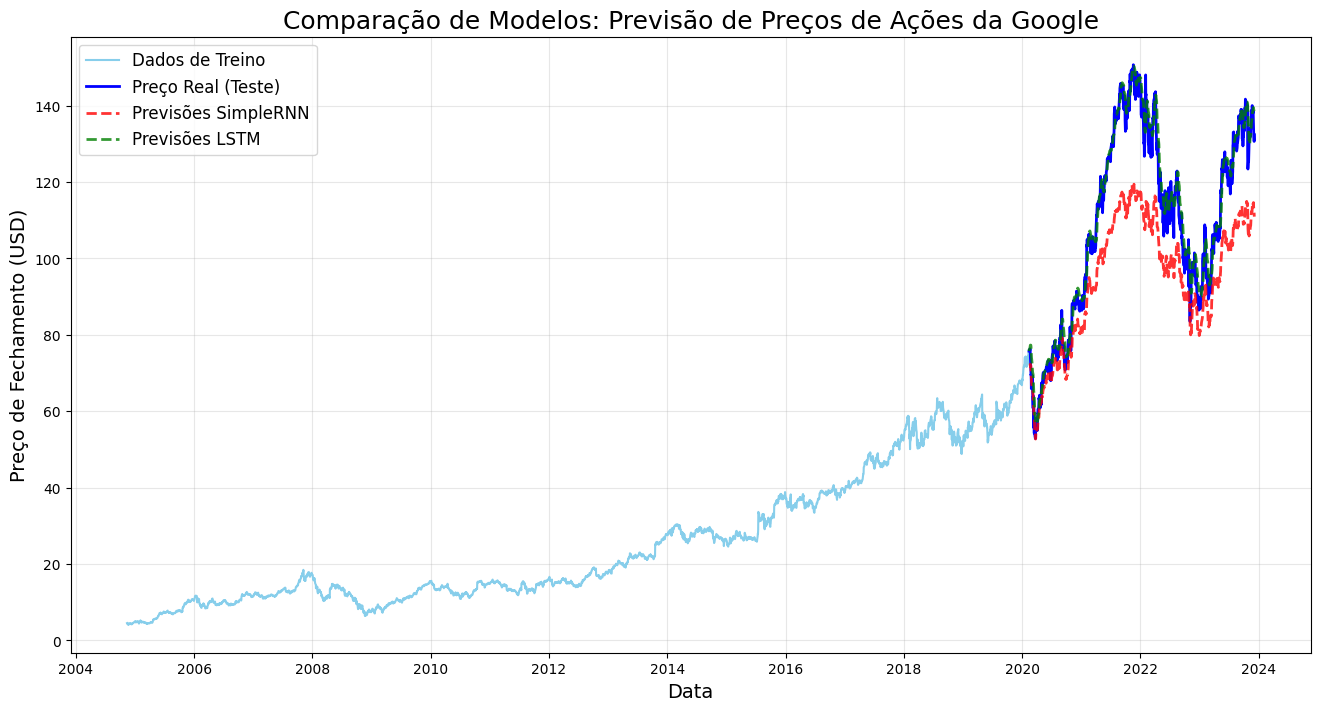

In [14]:
# Preparar dados para plotagem
train_len = len(data) - len(y_test_real)
train = data.iloc[window_size:train_len]
valid = data.iloc[train_len:]
valid['RNN_Predictions'] = rnn_predictions
valid['LSTM_Predictions'] = lstm_predictions

# Plotar os resultados
plt.figure(figsize=(16, 8))
plt.title('Comparação de Modelos: Previsão de Preços de Ações da Google', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Preço de Fechamento (USD)', fontsize=14)

# Dados de treino e reais
plt.plot(train['Close'], label='Dados de Treino', color='skyblue', linewidth=1.5)
plt.plot(valid['Close'], label='Preço Real (Teste)', color='blue', linewidth=2)

# Previsões
plt.plot(valid['RNN_Predictions'], label='Previsões SimpleRNN', color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(valid['LSTM_Predictions'], label='Previsões LSTM', color='green', linestyle='--', linewidth=2, alpha=0.8)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### 7.2 Visualização com Zoom na Área de Previsão

Para analisar melhor a performance, vamos focar apenas na área de teste, onde as predições foram feitas.

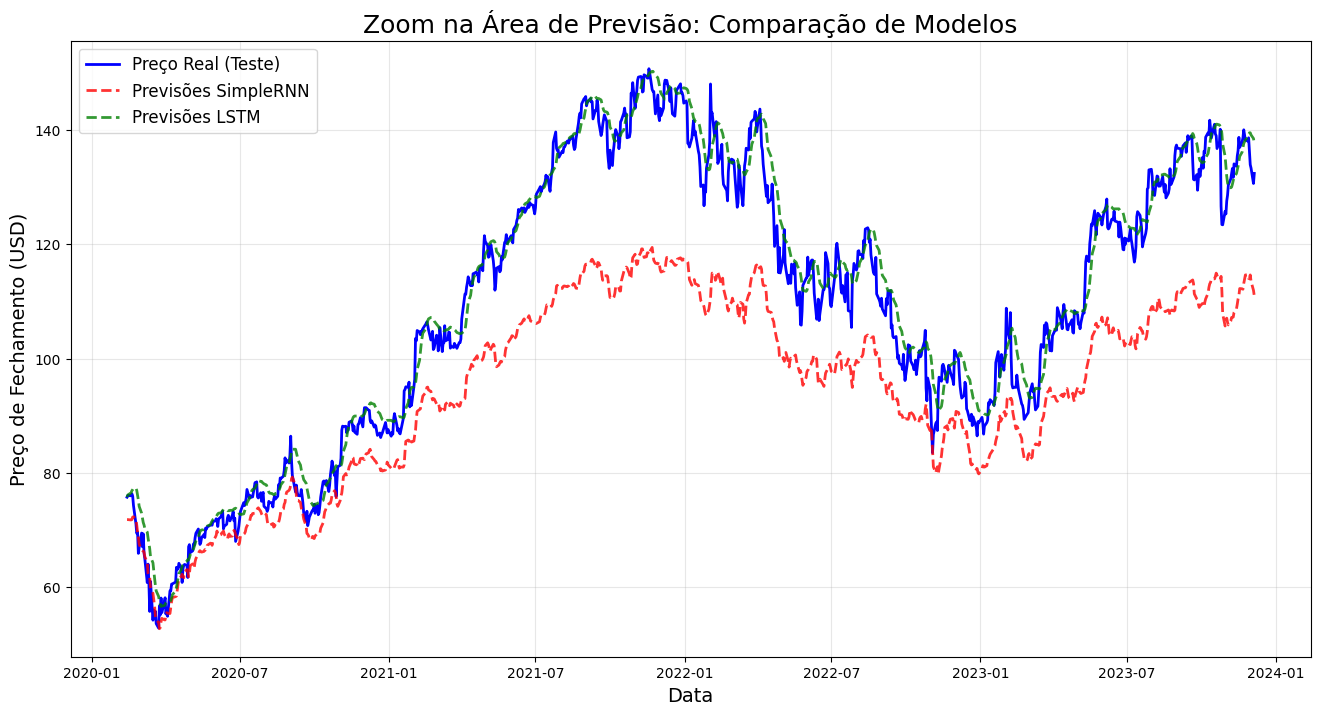

In [15]:
# Plotar apenas a área de validação (zoom)
plt.figure(figsize=(16, 8))
plt.title('Zoom na Área de Previsão: Comparação de Modelos', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Preço de Fechamento (USD)', fontsize=14)

# Dados reais e previsões
plt.plot(valid['Close'], label='Preço Real (Teste)', color='blue', linewidth=2)
plt.plot(valid['RNN_Predictions'], label='Previsões SimpleRNN', color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(valid['LSTM_Predictions'], label='Previsões LSTM', color='green', linestyle='--', linewidth=2, alpha=0.8)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 8. Conclusão Final

O gráfico com zoom na área de predição deixa a diferença de performance entre os dois modelos explícita:

1.  **SimpleRNN (Linha Vermelha):** A previsão da RNN Simples exibe um claro **"lag" (atraso)**. A linha vermelha parece ser uma cópia da linha azul (preço real), mas deslocada para a direita. Isso indica que o modelo não aprendeu a prever a tendência futura; ele simplesmente aprendeu a prever que o preço de amanhã será muito parecido com o de hoje. Essa é uma falha clássica em tarefas de séries temporais complexas e demonstra a **incapacidade da SimpleRNN de reter informações de longo prazo** devido ao problema do gradiente desvanecente.

2.  **LSTM (Linha Verde):** Em contraste, a previsão da LSTM acompanha o preço real de forma muito mais precisa e reativa. Embora não seja perfeita, a linha verde consegue capturar a **direção e a magnitude** das flutuações de preço com muito mais sucesso. Isso ocorre porque os portões da LSTM (esquecer, entrada e saída) permitem que o modelo **controle o fluxo de informação**, "lembrando" de padrões importantes de dias ou semanas anteriores e "esquecendo" o que é irrelevante.

Este exemplo prático ilustra perfeitamente por que as LSTMs são a escolha padrão para a maioria das tarefas de séries temporais em vez das RNNs Simples. A capacidade da LSTM de gerenciar sua memória interna é a chave para modelar dependências de longo prazo, algo que a SimpleRNN não consegue fazer de forma eficaz.